# Deep Learning Project

The current project relies on using CNNs in order to process sperm data. 
The goal is to develop a classifier able to identify different morphologies of head spearm cells

The model is not yet fuly defined. We will start with a standard CNN to Dense Layer.

The goal is for images to be loaded into the CNN. The CNN will will then perform feature extraction and those will be fed to the final model.

In [1]:
#need this to run keras with GPU
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
#
#Check Computer's available devices
#Will need to check in the future
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

#cfg 1
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

#cfg2
config = tf.compat.v1.ConfigProto(gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8))
# device_count = {'GPU': 1})
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 8671979738044613355
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9564624936758673909
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4971491488
locality {
  bus_id: 1
  links {
  }
}
incarnation: 3825531833145582887
physical_device_desc: "device: 0, name: GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 16041120727644941969
physical_device_desc: "device: XLA_GPU device"
]


In [2]:
#base libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

import matplotlib.image as mpimg
%matplotlib inline

from timeit import default_timer as timer



#image manipulation packages
import cv2
import os
from tqdm import tqdm
from glob import glob
from sklearn.metrics import confusion_matrix,classification_report


#Classification
from sklearn.metrics import classification_report, confusion_matrix, multilabel_confusion_matrix

sns.set()

#import keras
from tensorflow import keras
import glob
import cv2
import shutil
import random
import Augmentor


from itertools import cycle

#Data Augmentation
from keras.preprocessing.image import ImageDataGenerator

# Callbacks
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from scipy import interp
## RESNET50

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import callbacks

# 1- Import Images and Dataframe

In this case, we have a folder with 1132 image - SCIAN-MorphoSpermGS folder - https://cimt.uchile.cl/gold10/. Each image is 35 x 35 pixels and has been classified by 3 experts. We will use majority vote result as target. Each image will need to be loaded and the dataset will need to be created.

#### This will yield a dataset with the picture name and the label.

In [3]:
dataframe=pd.read_csv("Majority_Vote.csv")

In [4]:
os.chdir('path')
path = os.getcwd()
files = os.listdir(path)

In [5]:
path

'C:\\Users\\Ricardo Santos\\Desktop\\Mestrado Ricardo\\Ano 1\\Spring Semester\\Deep\\Deep_Learning_Project\\CNN_SpermCells\\path'

In [6]:
Alex_train_datagen = ImageDataGenerator(rescale = 1./255,
                                   rotation_range = 5,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.1, 
                                   vertical_flip = True,
                                   horizontal_flip = True,
                                   brightness_range=[0.2,1.5], 
                                   fill_mode='nearest',
                                   zoom_range = 0.2,
                                   ) 

Alex_val_datagen = ImageDataGenerator(rescale = 1./255)
Alex_test_datagen = ImageDataGenerator(rescale = 1./255)

#test different color maps -  class modes and cross validation types
Alex_training = Alex_train_datagen.flow_from_directory(path+'/train',
                                                 target_size = (32, 32),
                                                 batch_size = 64,
                                                 shuffle = True,
                                                 class_mode="categorical",
                                                 color_mode = 'grayscale')

Alex_val = Alex_val_datagen.flow_from_directory(path+'/val',
                                            target_size = (32, 32),
                                            batch_size = 64,
                                            shuffle = True,
                                            class_mode="categorical",
                                            color_mode = 'grayscale')

Alex_test = Alex_test_datagen.flow_from_directory(path+'/test',
                                            target_size = (32, 32),
                                            batch_size = 1,
                                            shuffle = True,
                                            class_mode="categorical",
                                            color_mode = 'grayscale')

Found 25600 images belonging to 4 classes.
Found 383 images belonging to 4 classes.
Found 130 images belonging to 4 classes.


In [7]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20, restore_best_weights = True)

checkpoint_filepath = path+'/Models/AlexNet_GS.h5'
mc = ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose = 1,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

class TimingCallback(keras.callbacks.Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_epoch_begin(self, epoch, logs={}):
        self.starttime = timer()
    def on_epoch_end(self, epoch, logs={}):
        self.logs.append(timer()-self.starttime)

cb = TimingCallback()

#### 4.1 Preprocess input
Online Data Augmentation  in RGB

#### 4.2 Build model  

In [8]:
#Instantiation
AlexNet = Sequential()

#1st Convolutional Layer - Alexnet took 224px imgs, which we do not have here, we will adjust layers accordingly 
#by reducing first first stride and max pool. All other layers will remain the same

AlexNet.add(Conv2D(filters=96, input_shape=(32,32,1), kernel_size=(4,4), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#2nd Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#3rd Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#4th Convolutional Layer
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

##5th Convolutional Layer
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
AlexNet.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

#Passing it to a Fully Connected layer
AlexNet.add(Flatten())

# 1st Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

# Add Dropout to prevent overfitting
AlexNet.add(Dropout(0.4))

#2nd Fully Connected Layer
AlexNet.add(Dense(4096))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))

#Add Dropout
AlexNet.add(Dropout(0.4))

#3rd Fully Connected Layer
AlexNet.add(Dense(1024))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('relu'))
#Add Dropout
AlexNet.add(Dropout(0.4))

#Output Layer
AlexNet.add(Dense(4))
AlexNet.add(BatchNormalization())
AlexNet.add(Activation('softmax'))

#Model Summary
AlexNet.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 96)        1632      
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 256)       0

#### 4.3 Compile model

In [9]:
AlexNet.compile(loss = keras.losses.categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])

#### 4.4 Fit model

In [10]:
history = AlexNet.fit(Alex_training,
        epochs=200, 
        validation_data=Alex_val,
        verbose = 1, 
        callbacks = [mc, reduce_lr, es,cb])

Epoch 1/200
400/400 [==============================] - 24s 50ms/step - loss: 1.3802 - accuracy: 0.3083 - val_loss: 1.6502 - val_accuracy: 0.1253

Epoch 00001: val_accuracy improved from -inf to 0.12533, saving model to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\CNN_SpermCells\path/Models\AlexNet_GS.h5
Epoch 2/200
400/400 [==============================] - 19s 47ms/step - loss: 1.2005 - accuracy: 0.4508 - val_loss: 1.7257 - val_accuracy: 0.2924

Epoch 00002: val_accuracy improved from 0.12533 to 0.29243, saving model to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spring Semester\Deep\Deep_Learning_Project\CNN_SpermCells\path/Models\AlexNet_GS.h5
Epoch 3/200
400/400 [==============================] - 18s 46ms/step - loss: 1.0566 - accuracy: 0.5368 - val_loss: 1.1703 - val_accuracy: 0.4700

Epoch 00003: val_accuracy improved from 0.29243 to 0.46997, saving model to C:\Users\Ricardo Santos\Desktop\Mestrado Ricardo\Ano 1\Spri

#### 4.5 Evaluate  model

6/6 [==============================] - 0s 30ms/step - loss: 0.7776 - accuracy: 0.6762
Train: 0.704, Val: 0.676


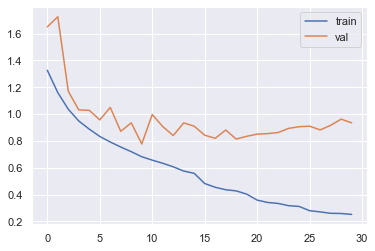

In [11]:
_, train_acc = AlexNet.evaluate(Alex_training, verbose=1)
_, val_acc = AlexNet.evaluate(Alex_val, verbose=1)
print('Train: %.3f, Val: %.3f' % (train_acc, val_acc))

# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

In [12]:
test_loss, test_acc = AlexNet.evaluate(Alex_test)

print('Test loss:', test_loss)
print('Test accuracy:', test_acc)
print("\nTime:",sum(cb.logs)/60,"min")

130/130 [==============================] - 1s 6ms/step - loss: 0.7587 - accuracy: 0.6692
Test loss: 0.7586769461631775
Test accuracy: 0.6692307591438293

Time: 9.78663611833333 min


#### 4.5 Make Predictions

In [13]:
#get predicted probality
prediction = AlexNet.predict(Alex_test,verbose=1)

#Get class of prediction
predicted_class = np.argmax(prediction,axis=1)

#get trueclass
true_classes = Alex_test.classes

# get names of pictures
filenames = Alex_test.filenames

#store info in dataframe
alex_predictions = pd.DataFrame({'Filename': filenames, 'Label': true_classes, 'AlexNet': predicted_class})

130/130 [==============================] - 1s 4ms/step


In [14]:
Alex_pred =  pd.DataFrame(prediction, columns = ['Class 0', 'Class 1', 'Class 2', 'Class 3'], index = filenames)

Alex_pred.to_csv(path+'/Models/AlexG_pred_prob.csv')

Alex_pred

,Class 0,Class 1,Class 2,Class 3
class0\ch00_p1-pl2-sample10-sperm1.tif,0.010409,0.168634,0.022874,0.798083
class0\ch00_p1-pl2-sample10-sperm4.tif,0.003367,0.100927,0.003849,0.891857
class0\ch00_p1-pl2-sample12-sperm9.tif,0.007614,0.111487,0.044701,0.836198
class0\ch00_p1-pl2-sample5-sperm3.tif,0.019141,0.004165,0.020964,0.955731
class0\ch00_p1-pl3-sample14-sperm3.tif,0.229682,0.507729,0.053226,0.209363
...,...,...,...,...
class3\ch00_p5-pl1-sample9-sperm5.tif,0.024238,0.570555,0.014953,0.390254
class3\image_010.BMP,0.004458,0.041242,0.013300,0.941000
class3\image_013.BMP,0.016344,0.437260,0.075665,0.470732
class3\image_014.BMP,0.347339,0.010975,0.286403,0.355283


In [15]:
alex_predictions

,Filename,Label,AlexNet
0,class0\ch00_p1-pl2-sample10-sperm1.tif,0,3
1,class0\ch00_p1-pl2-sample10-sperm4.tif,0,3
2,class0\ch00_p1-pl2-sample12-sperm9.tif,0,3
3,class0\ch00_p1-pl2-sample5-sperm3.tif,0,3
4,class0\ch00_p1-pl3-sample14-sperm3.tif,0,1
...,...,...,...
125,class3\ch00_p5-pl1-sample9-sperm5.tif,3,1
126,class3\image_010.BMP,3,3
127,class3\image_013.BMP,3,3
128,class3\image_014.BMP,3,3


#### 4.7  Confusion matrix and classification report

In [16]:
def metrics(y_train, pred_train , y_val, pred_val):
    print('___________________________________________________________________________________________________________')
    print('                                                     TRAIN                                                 ')
    print('----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_train, pred_train))
    print(confusion_matrix(y_train, pred_train))


    print('___________________________________________________________________________________________________________')
    print('                                                VALIDATION                                                 ')
    print('-----------------------------------------------------------------------------------------------------------')
    print(classification_report(y_val, pred_val))
    print(confusion_matrix(y_val, pred_val))

In [17]:
train_labels, val_labels = Alex_training.classes, Alex_val.classes
pred_train, pred_val = np.argmax(AlexNet.predict(Alex_training), axis = 1), np.argmax(AlexNet.predict(Alex_val), axis = 1)

metrics(train_labels, pred_train , val_labels, pred_val)

___________________________________________________________________________________________________________
                                                     TRAIN                                                 
----------------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.25      0.28      0.27      6400
           1       0.25      0.31      0.28      6400
           2       0.24      0.16      0.19      6400
           3       0.25      0.24      0.25      6400

    accuracy                           0.25     25600
   macro avg       0.25      0.25      0.25     25600
weighted avg       0.25      0.25      0.25     25600

[[1768 1921 1138 1573]
 [1707 1994 1098 1601]
 [1755 2026 1046 1573]
 [1713 1997 1124 1566]]
___________________________________________________________________________________________________________
                                         

In [18]:
class_labels = list(Alex_test.class_indices.keys())   

print(confusion_matrix(true_classes, predicted_class))

report = classification_report(true_classes, predicted_class, target_names=class_labels)
print(report)

[[ 2  1  3 10]
 [ 4  7  5 13]
 [ 4  4  1  5]
 [15 16  8 32]]
              precision    recall  f1-score   support

      class0       0.08      0.12      0.10        16
      class1       0.25      0.24      0.25        29
      class2       0.06      0.07      0.06        14
      class3       0.53      0.45      0.49        71

    accuracy                           0.32       130
   macro avg       0.23      0.22      0.22       130
weighted avg       0.36      0.32      0.34       130



### ROC CURVES AND PRECISION RECALL

In [19]:
#VAL DATA

y_pred = AlexNet.predict(Alex_val)
y_real = val_labels

In [20]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_real = label_binarize(y_real, classes=[0, 1, 2, 3])
#y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3])
n_classes = y_real.shape[1]

In [21]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_real[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_real.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-22-70844e3c8198>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


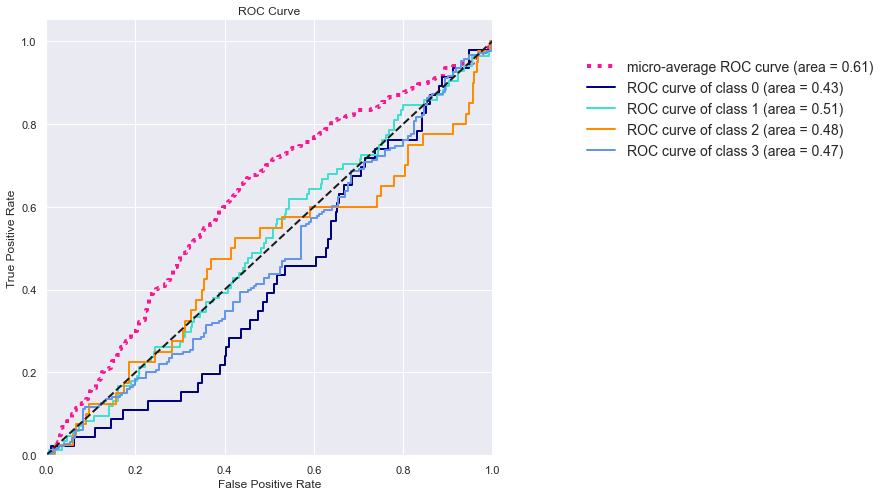

In [22]:
lw=2


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
         #label='macro-average ROC curve (area = {0:0.2f})'
               #''.format(roc_auc["macro"]),
         #color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.legend(loc=(1.2, 0.67), prop=dict(size=14), frameon=False)

#make it pretty
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)

plt.show()

In [23]:
#PRecision Recall

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_real[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_real[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_real.ravel(), y_pred.ravel())
average_precision["micro"] = average_precision_score(y_real, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.32


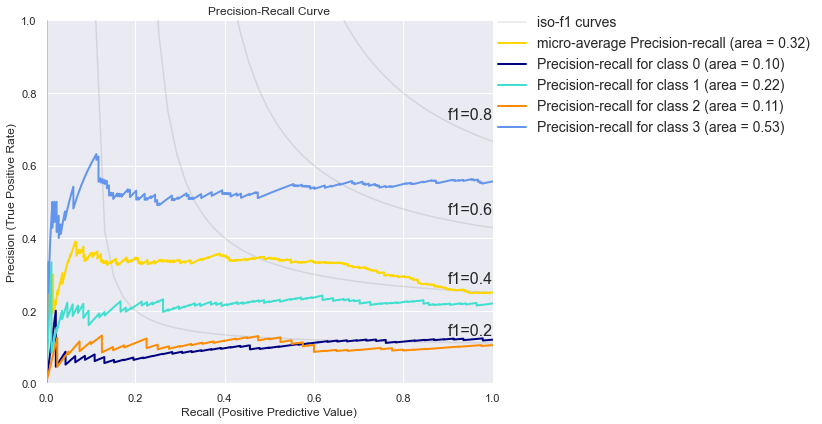

In [24]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    
#plot
fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall (Positive Predictive Value)')
plt.ylabel('Precision (True Positive Rate)')
plt.title('Precision-Recall Curve')
plt.legend(lines, labels, loc=(1, 0.67), prop=dict(size=14), frameon=False)

#make it pretty
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)


plt.show()

## Test Data

In [25]:
#VAL DATA

y_pred = prediction
y_real = true_classes

In [26]:
from sklearn.preprocessing import label_binarize
# Binarize the output
y_real = label_binarize(y_real, classes=[0, 1, 2, 3])
#y_pred = label_binarize(y_pred, classes=[0, 1, 2, 3])
n_classes = y_real.shape[1]

In [27]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(4):
    fpr[i], tpr[i], _ = roc_curve(y_real[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_real.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

<ipython-input-28-70844e3c8198>:10: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


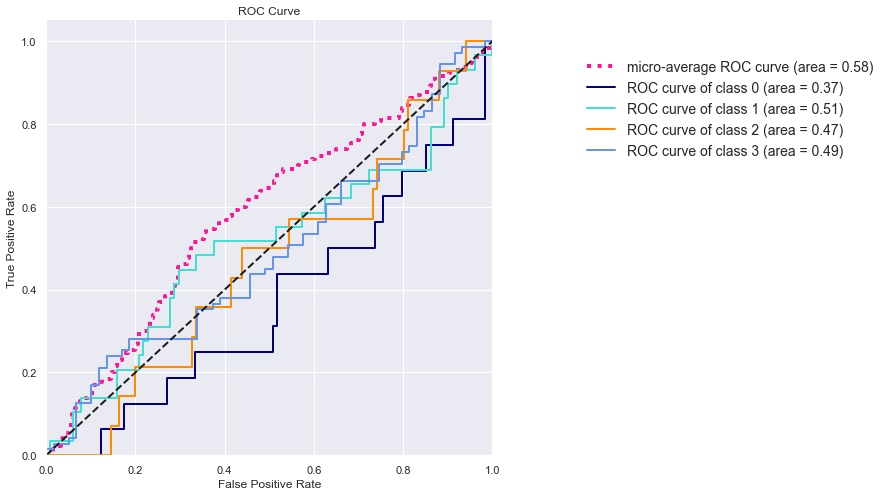

In [28]:
lw=2


# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(8, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

#plt.plot(fpr["macro"], tpr["macro"],
         #label='macro-average ROC curve (area = {0:0.2f})'
               #''.format(roc_auc["macro"]),
         #color='navy', linestyle=':', linewidth=4)

colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.legend(loc=(1.2, 0.67), prop=dict(size=14), frameon=False)

#make it pretty
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)

plt.show()

### Precision-Recall Curve

In [29]:
#PRecision Recall

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_real[:, i],
                                                        y_pred[:, i])
    average_precision[i] = average_precision_score(y_real[:, i], y_pred[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_real.ravel(), y_pred.ravel())
average_precision["micro"] = average_precision_score(y_real, y_pred,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.30


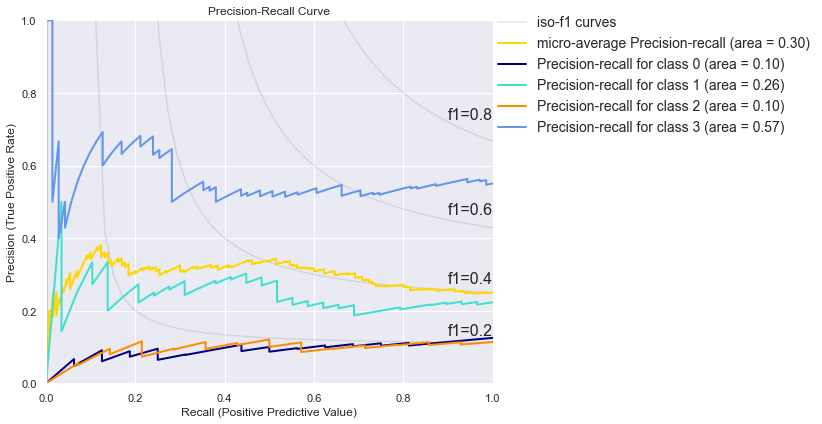

In [30]:
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(8, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'.format(i, average_precision[i]))
    
#plot
fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('Recall (Positive Predictive Value)')
plt.ylabel('Precision (True Positive Rate)')
plt.title('Precision-Recall Curve')
plt.legend(lines, labels, loc=(1, 0.67), prop=dict(size=14), frameon=False)

#make it pretty
for pos in ['right', 'top']:
    plt.gca().spines[pos].set_visible(False)


plt.show()